# emcee model man

In [4]:
## remember to add extinction to their data!!!

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as const
import astropy
import pysynphot as S
import emcee

k = 1
M_c = 1 
distance = 26.4 * 10**6 * u.pc
# theta = [v85, R13, M_e, offset] 

we want to find - R_e, v_e, M_e, offset 
for n=3/2[3]

# Functions

In [5]:
def f_p(n, M_e):
    """
    returns the ratio between the enitial mass and the core mass.
    """
    if n == 3/2:
        return (M_e/M_c)**0.5
    elif n == 3:
        return 0.08 * (M_e/M_c)
    

def L(n, t, theta):
    """
    t - days, M_e - solMass, v85 - vs * 10**-8.5 * cm * s**-1, R13 - R_e * 10**-13 * cm
    """
    v85, R13, M_e, offset = theta
    t_offset = t - offset
    if n == 3/2:
        nums = [1.88, -0.086, 1.67, 0.8]
    else:
        nums = [1.66, -0.175,4.57, 0.73]
    A = nums[0] * 10**42
    B = (v85 / (f_p(n, M_e) * (M_e + M_c) * k))
    C = (v85**2 * (R13 / k))
    D = (nums[2] / (19.5 * np.sqrt(k * M_e * v85**-1)))
    
    return A * ((B * t_offset**2)**nums[1]) * C *np.exp(-(D * t_offset)**nums[3]) * u.erg / u.s

def T(n, t, theta):
    """
    the color temp is given by this function.
    where t is in days and M is in solar masses.
    """
    v85, R13, M_e, offset = theta
    t_offset = t - offset
    if n == 3/2:
        nums = [2.05, 0.027]
    else:
        nums = [1.96, 0.016]
    T = nums[0] * 10**4 *(((v85 * t_offset)**2) / (f_p(n, M_e) * (M_e + M_c) * k))**nums[1] * (R13 / k)**0.25 * t_offset**-0.5
    return T * u.K

def R(n, t, theta):
    """
    gets t in days, then converts the result to rsun
    R^2 = sqrt(L(t)/4pi sigma T^4)
    """
    sigma_sb = const.sigma_sb.to(u.erg * u.cm**-2 * u.s**-1 * u.K**-4)
    return np.sqrt(L(n,t, theta) / (4 * np.pi * sigma_sb * T(n, t, theta)**4)).to(u.solRad)

def get_mag(n, t, theta):
    mag = []
    for temp in T(n, t, theta).value:
        bb = S.BlackBody(temp)

        bp = S.ObsBandpass('v')

        obs = S.Observation(bb, bp)

        mag.append(obs.effstim('VegaMag'))
    return np.array(mag) - 2.5*np.log10(((R(n, t, theta) / (1 * u.solRad))**2)*((1000.0 * u.pc/distance)**2))

def log_prior(theta):
    """
    i used the values Iair gave me, plus the times we expect the explosion to occur (by their paper)
    """
    v85, R13, M_e, offset = theta
    R_e = R13 * 1e13
    v_e = v85 * 10**8.5
    if R_e > 1e10 and R_e < 1e14 and v_e > 100e5 and v_e < 100000e5 and M_e > 0.005 and M_e < 1 and\
    offset > 0.70342593 and offset < 0.73376157:
        return 0 # log(1)
    else:
        return -np.inf  # log(0)
    
def log_likelihood(n, theta, t, meas_mag, meas_mag_err):
    meas_flux = mag_to_flux(meas_mag)
    meas_flux_err = mag_to_fluxerr(meas_mag, meas_mag_err)
    
    expected_flux = mag_to_flux(get_mag(n, t, theta))
    
    chi2 = get_chi2(meas_flux, meas_flux_err, expected_flux)
    
    normalization = get_normalization(meas_flux)
    
    return -0.5 * np.sum(normalization + chi2)
    
def mag_to_flux(mag):
    return 10**(-0.4*mag)

def mag_to_fluxerr(mag, mag_err):
    return abs(mag_to_flux(mag)*(-0.4)*np.log(10)*mag_err)

def get_chi2(meas, meas_err, expected):
    return ((meas - expected)/meas_err)**2

def get_normalization(meas):
    return np.log(2 * np.pi * meas**2)
    
    
def log_postirior(theta, n, t, meas_mag, meas_mag_err):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(n, theta, t, meas_mag, meas_mag_err)

def set_walkers(nwalkers):
    """
    # initialize walkers -  theta = [v85, R13, M_e, offset] 
    """
    initial_guess = [1.7,0.4,0.02,0.715]
    initial_spread = [0.2,0.2,0.002,0.01]
    
    return np.random.randn(nwalkers, 4) * initial_spread + initial_guess

def t_bigger_than(n, theta):
    v85, R13, M_e, offset = theta
    return (0.2 * R13 * v85**-1 * max(0.5, (R13**0.4 * (f_p(n, M_e) * k * (M_e + M_c)**-0.2 * v85**-0.7))))

def t_smaller_than(n, theta):
    v85, R13, M_e, offset = theta
    return (7.4 * (R13 / k)**0.55)

    

# getting the data from excel

In [20]:
def getting_data(sheet_name):
    path = r"C:\Users\User\OneDrive - mail.tau.ac.il\Desktop\אוניברסיטה\אסטרו נודר\פרויקט קיץ\התחלה של קוד\astro_summer_project\starting with data\excel files\combined_data.xlsx"

    data = pd.read_excel(path, sheet_name=sheet_name)

    t = np.array(data.loc[:, 'JD - 2457651.0[day]'])
    meas_mag = np.array(data.loc[:, 'V[mag]'])
    meas_mag_err = np.array(data.loc[:, 'error_V[mag]'])

    return t, meas_mag, meas_mag_err


In [22]:
t, meas_mag, meas_mag_err = getting_data('after ext binning')

# MCMC 

In [10]:
# from multiprocessing import Pool

n = 3/2
initial_pos = set_walkers(16)
nwalkers, ndim = initial_pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_postirior, 
                                args=(n, t, meas_mag, meas_mag_err))
print("Started MCMC")

sampler.run_mcmc(initial_pos, 250, progress=True);

Started MCMC


  0%|                                                                                          | 0/250 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [18:35<00:00,  4.46s/it]


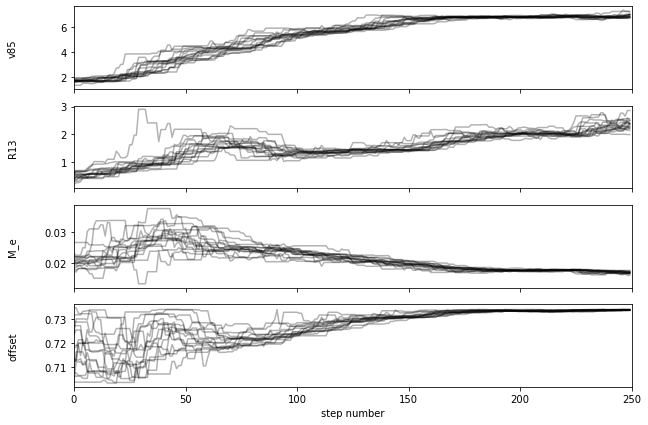

In [11]:
# theta = [v85, R13, M_e, offset] 
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["v85", "R13", "M_e", "offset"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

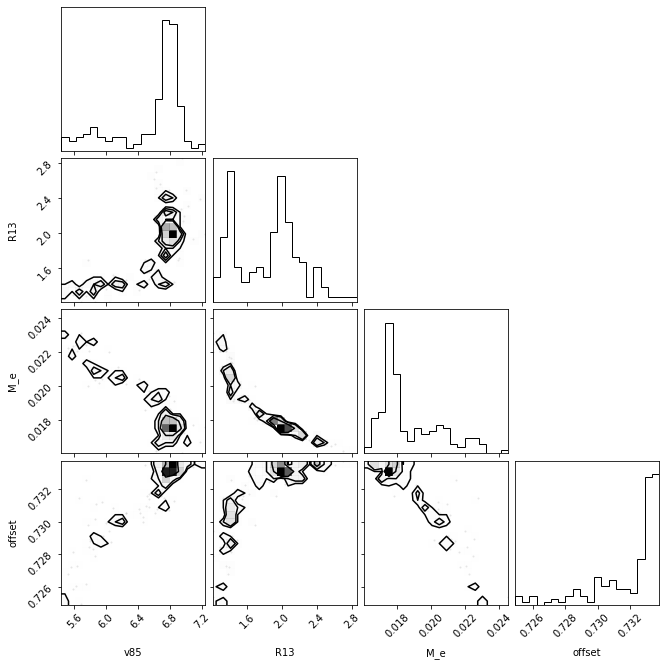

In [12]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
import corner

fig = corner.corner(
    flat_samples, labels=labels
);

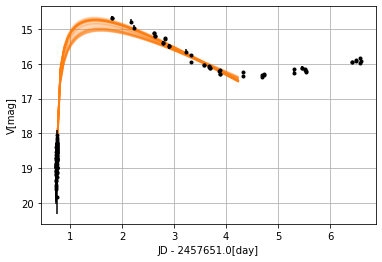

In [23]:
## i need to first add the offset so that itr will be reduces, and then add it to the x values so that it makes sense on the data.
inds = np.random.randint(len(flat_samples), size=100)
time = np.linspace(0.01, 3.5)
for ind in inds:
    theta = flat_samples[ind]
    v85, R13, M_e, offset = theta
    
#     time = np.linspace(t_bigger_than(n, theta), t_smaller_than(n, theta))
    
    plt.plot(time+offset, get_mag(n, time+offset, theta), "C1", alpha=0.1)
    
all_t, all_mag, all_mag_err = getting_data('after extinction')
# plt.errorbar(t, meas_mag, yerr=meas_mag_err, fmt=".k", capsize=0)
plt.errorbar(all_t, all_mag, yerr=all_mag_err, fmt=".k", capsize=0)

            
plt.xlabel('JD - 2457651.0[day]')
plt.ylabel('V[mag]')
plt.gca().invert_yaxis()
plt.grid()
plt.show();

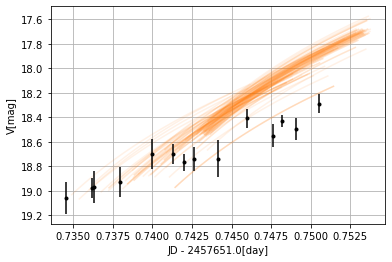

In [19]:
## i need to first add the offset so that itr will be reduces, and then add it to the x values so that it makes sense on the data.
inds = np.random.randint(len(flat_samples), size=100)
time = np.linspace(0.01, 0.02)
for ind in inds:
    theta = flat_samples[ind]
    v85, R13, M_e, offset = theta
    
#     time = np.linspace(t_bigger_than(n, theta), t_smaller_than(n, theta))
    
    plt.plot(time+offset, get_mag(n, time+offset, theta), "C1", alpha=0.1)
plt.errorbar(t[:14], meas_mag[:14], yerr=meas_mag_err[:14], fmt=".k", capsize=0)

            
plt.xlabel('JD - 2457651.0[day]')
plt.ylabel('V[mag]')
plt.gca().invert_yaxis()
plt.grid()
plt.show();

In [30]:
# from multiprocessing import Pool

n = 3
initial_pos = set_walkers(16)
nwalkers, ndim = initial_pos.shape

sampler3 = emcee.EnsembleSampler(nwalkers, ndim, log_postirior, 
                                args=(n, t, meas_mag, meas_mag_err))
print("Started MCMC")

sampler3.run_mcmc(initial_pos, 250, progress=True);

Started MCMC


  0%|                                                                                          | 0/250 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [17:57<00:00,  4.31s/it]


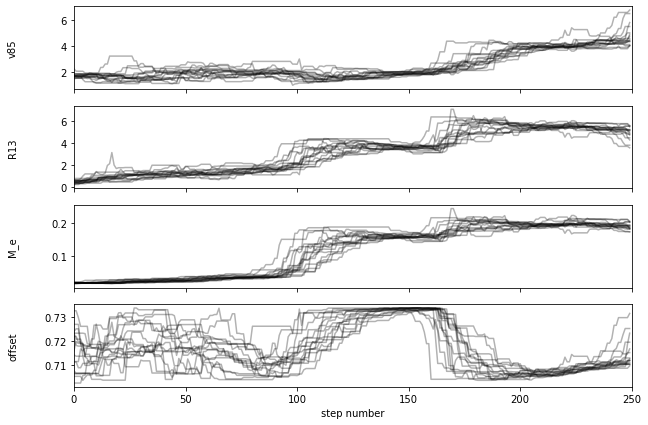

In [39]:
# theta = [v85, R13, M_e, offset] 
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples3 = sampler3.get_chain()
labels = ["v85", "R13", "M_e", "offset"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples3[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples3))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

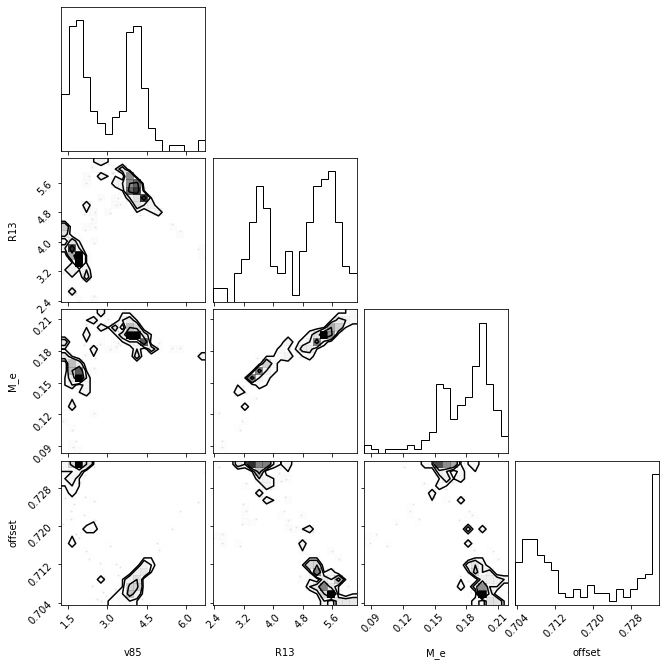

In [35]:
flat_samples3 = sampler3.get_chain(discard=100, thin=15, flat=True)
import corner

fig = corner.corner(
    flat_samples3, labels=labels
);

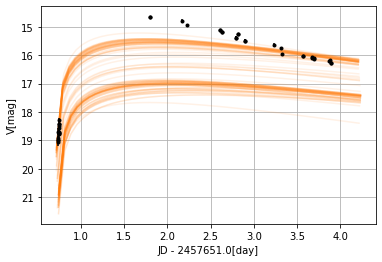

In [33]:
## i need to first add the offset so that itr will be reduces, and then add it to the x values so that it makes sense on the data.
inds = np.random.randint(len(flat_samples3), size=100)
time = np.linspace(0.01, 3.5)
for ind in inds:
    theta = flat_samples3[ind]
    v85, R13, M_e, offset = theta
    
#     time = np.linspace(t_bigger_than(n, theta), t_smaller_than(n, theta))
    
    plt.plot(time+offset, get_mag(n, time+offset, theta), "C1", alpha=0.1)
plt.errorbar(t, meas_mag, yerr=meas_mag_err, fmt=".k", capsize=0)

            
plt.xlabel('JD - 2457651.0[day]')
plt.ylabel('V[mag]')
plt.gca().invert_yaxis()
plt.grid()
plt.show();

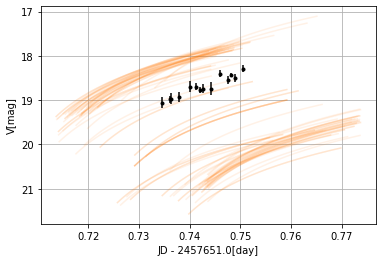

In [37]:
## i need to first add the offset so that itr will be reduces, and then add it to the x values so that it makes sense on the data.
inds = np.random.randint(len(flat_samples3), size=100)
time = np.linspace(0.01, 0.04)
for ind in inds:
    theta = flat_samples3[ind]
    v85, R13, M_e, offset = theta
    
#     time = np.linspace(t_bigger_than(n, theta), t_smaller_than(n, theta))
    
    plt.plot(time+offset, get_mag(n, time+offset, theta), "C1", alpha=0.1)
plt.errorbar(t[:14], meas_mag[:14], yerr=meas_mag_err[:14], fmt=".k", capsize=0)

            
plt.xlabel('JD - 2457651.0[day]')
plt.ylabel('V[mag]')
plt.gca().invert_yaxis()
plt.grid()
plt.show();